## Plotting mean functional response maps

In this example, we show how to plot the maps of mean functional response for small sizes (0 to 3cm)

Note that the ``apecosm.extract_weighted_data`` function cannot be used here, since the latter computes weighted **horizontal averages** of variables such as the functional response, and therefore produces time-series rather than maps

In [1]:
import os
import apecosm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes

In [2]:
mesh_file = os.path.join('..', 'data', 'pacific_mesh_mask.nc')

In [3]:
mesh = apecosm.open_mesh_mask(mesh_file)

In [4]:
dirin = os.path.join('..', 'data', 'apecosm')

In [5]:
const = apecosm.open_constants(dirin)

In [6]:
data = apecosm.open_apecosm_data(dirin, replace_dims={'community': 'c'})

Now, we extract the biomass density and convert it using the `weight_step` variable, in order to obtain values in $J.m^{-2}$

In [7]:
oope = (data['OOPE'] * const['weight_step'])
oope

<xarray.DataArray (time: 12, y: 108, x: 163, c: 5, w: 100)>
dask.array<mul, shape=(12, 108, 163, 5, 100), dtype=float64, chunksize=(12, 108, 163, 5, 100), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2018-01-16 00:00:00 ... 2018-12-16 00:00:00
Dimensions without coordinates: y, x, c, w

Now we keep the `oope` variable where the length is greater than 3cm. OOPE for greater sizes is set to 0

In [8]:
oope_small = oope.where(const['length'] * 100 <= 3)
oope_small = oope_small.fillna(0)

<xarray.DataArray (time: 12, y: 108, x: 163, c: 5, w: 100)>
dask.array<where, shape=(12, 108, 163, 5, 100), dtype=float64, chunksize=(12, 108, 163, 5, 100), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2018-01-16 00:00:00 ... 2018-12-16 00:00:00
Dimensions without coordinates: y, x, c, w

Now we weight the functional response using the ``oope`` variable and we average over all dimensions but ``x``, ``y`` and ``c``.

In [9]:
repfunct = data['repfonct_day'].weighted(oope_small)
repfunct = repfunct.mean(dim=['time', 'w'])
repfunct = repfunct.compute()

The result is 5 maps, one for each community, showing the mean functional response for each community.

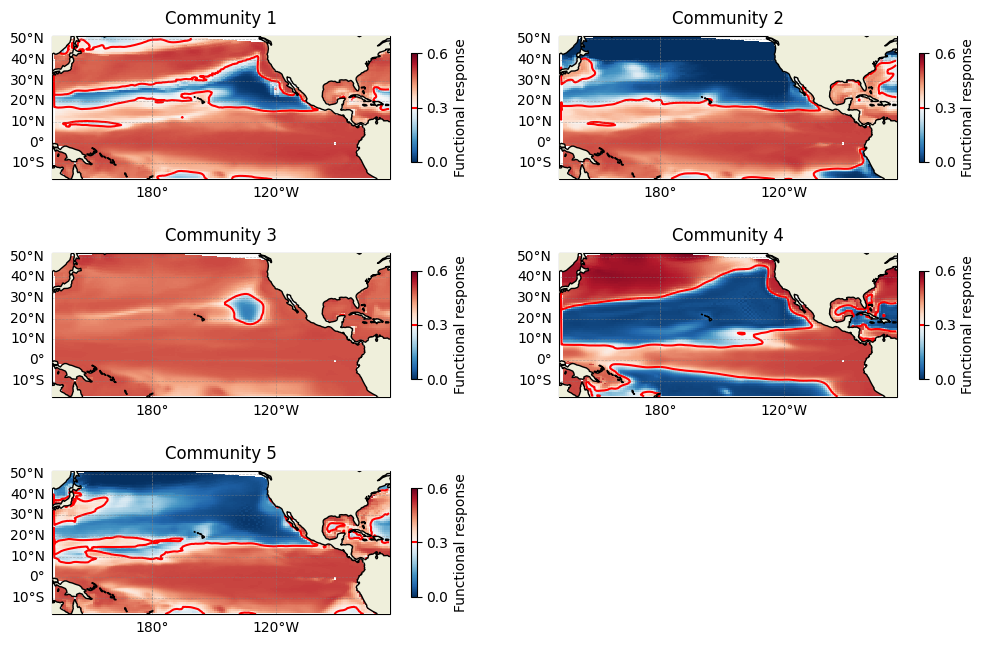

In [10]:
fig = plt.figure(figsize=(12, 8))

gridparams = {'crs': ccrs.PlateCarree(central_longitude=0), 'draw_labels':True, 
              'linewidth':0.5, 'color':'gray', 'alpha':0.5, 'linestyle':'--'}

plt.rcParams['image.cmap'] = 'RdBu_r'

for c in range(5):
    ax = plt.subplot(3, 2, c + 1, projection=ccrs.PlateCarree(central_longitude=180))
    cs = apecosm.plot_pcolor_map(repfunct.isel(c=c), mesh, axis=ax)
    cl = apecosm.plot_contour_map(repfunct.isel(c=c), mesh, axis=ax, filled=False, levels=[0.3], colors='red')
    cs.set_clim(0, 0.6)
    cb = plt.colorbar(cs, shrink=0.6)
    cb.set_label('Functional response')
    cb.set_ticks([0, 0.3, 0.6])
    cb.add_lines(cl)
    ax.set_title(f'Community {c + 1}')
    gl = ax.gridlines(**gridparams)
    gl.top_labels = False
    gl.right_labels = False